In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import seaborn as sns

In [4]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [5]:
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree

**Load Data**

In [6]:
kc_dt_url = "https://raw.githubusercontent.com/junjiewu-mtl/glis630_final_project/master/kc_house_data.csv"

In [7]:
url = kc_dt_url
hp_data = pd.read_csv(url)
#hp_data.count()

In [8]:
#converted week of year as a factor features
hp_data["date"] = hp_data["date"].str[0:8]
hp_data["formatted_date"] = pd.to_datetime(hp_data["date"])
hp_data['week_of_year'] = hp_data.formatted_date.apply(lambda x: x.weekofyear)


### Data Prep

In [58]:
#drop unuse features
df1 = hp_data.drop(["id", "date", "lat", "long", "sqft_living15", "sqft_lot15","formatted_date"], axis=1)

In [59]:
#covert features from numerical to factor
df1[['waterfront','view','condition','grade','zipcode', 'week_of_year','yr_built','yr_renovated']] = df1[['waterfront','view','condition','grade','zipcode','week_of_year','yr_built','yr_renovated']].astype('category')

In [61]:
df1 = pd.get_dummies(df1)
# Display the first 5 rows of the last 12 columns
df1.iloc[:,5:].head(5)

,floors,sqft_above,sqft_basement,waterfront_0,waterfront_1,view_0,view_1,view_2,view_3,view_4,...,week_of_year_43,week_of_year_44,week_of_year_45,week_of_year_46,week_of_year_47,week_of_year_48,week_of_year_49,week_of_year_50,week_of_year_51,week_of_year_52
0,1.0,1180,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2.0,2170,400,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,770,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,1050,910,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1.0,1680,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
df1.to_excel("input_jw.xlsx") 

## Regressiona Tree Model

In [13]:
rt_train_dt = df1.sample(frac=0.8, random_state=0)
rt_test_dt = df1.drop(rt_train_dt.index)

In [14]:
df1.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,waterfront_0,waterfront_1,...,week_of_year_43,week_of_year_44,week_of_year_45,week_of_year_46,week_of_year_47,week_of_year_48,week_of_year_49,week_of_year_50,week_of_year_51,week_of_year_52
0,221900.0,3,1.00,1180,5650,1.0,1180,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,538000.0,3,2.25,2570,7242,2.0,2170,400,1,0,...,0,0,0,0,0,0,0,1,0,0
2,180000.0,2,1.00,770,10000,1.0,770,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,604000.0,4,3.00,1960,5000,1.0,1050,910,1,0,...,0,0,0,0,0,0,0,1,0,0
4,510000.0,3,2.00,1680,8080,1.0,1680,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# regression tree method
rt_train_x = rt_train_dt.drop(["price"], axis=1)
rt_train_y = rt_train_dt[["price"]]

In [16]:
rt = tree.DecisionTreeRegressor()
rt.fit(rt_train_x, rt_train_y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [17]:
#predicted price from the regression tree
rt_predict_price = pd.DataFrame(rt.predict(rt_test_dt.drop(["price"], axis=1)), columns=["p_price"])

In [18]:
#add row number to predicted price for merging
rt_predict_price['index'] = np.arange(len(rt_predict_price))

In [19]:
#add row number to true price for merging
rt_test_price = rt_test_dt[['price']]
rt_test_price['index'] = np.arange(len(rt_test_price))

/Users/junjiewu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
#merge predicted and test price in to a df
rt_price = rt_predict_price.merge(rt_test_price, left_on='index', right_on='index').round(0)

In [23]:
#viz with plotly
import plotly.graph_objects as go

random_x = np.array([0,7000000])
random_y0 = np.array([0,7000000])

fig = go.Figure()

fig.add_trace(go.Scatter(x=rt_price['price'], y=rt_price['p_price'],
                    mode='markers',
                    name='markers'))

fig.add_trace(go.Scatter(x=random_x, y=random_y0,
                    mode='lines',
                    name='lines'))

fig

In [24]:
# Calculate the absolute errors
rt_errors = abs(rt_price['p_price'] - rt_price['price'])
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(rt_errors), 2), 'USD.')

Mean Absolute Error: 112253.62 USD.


In [25]:
# Calculate mean absolute percentage error (MAPE)
rt_mape = 100 * (rt_errors / rt_price['price'])
# Calculate and display accuracy
rt_accuracy = 100 - np.mean(rt_mape)
print('Accuracy:', round(rt_accuracy, 2), '%.')

#Accuracy: 78.74 %.

Accuracy: 78.8 %.


In [27]:
#MSE
from sklearn.metrics import mean_squared_error

mean_squared_error(rt_price['price'], rt_price['p_price'])

#39037669760.21212

39923938685.444595

## Regression Tree Finished HERE

In [9]:
#sorted(df1)


In [29]:
# Labels are the values we want to predict
rf_labels = np.array(df1['price'])
# Remove the labels from the features
# axis 1 refers to the columns
rf_features= df1.drop('price', axis = 1)
# Saving feature names for later use
rf_feature_list = list(rf_features.columns)
# Convert to numpy array
rf_features = np.array(rf_features)

In [30]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
rf_train_features, rf_test_features, rf_train_labels, rf_test_labels = train_test_split(rf_features, rf_labels, test_size = 0.25, random_state = 42)

In [31]:
print('Training Features Shape:', rf_train_features.shape)
print('Training Labels Shape:', rf_train_labels.shape)
print('Testing Features Shape:', rf_test_features.shape)
print('Testing Labels Shape:', rf_test_labels.shape)


Training Features Shape: (16209, 339)
Training Labels Shape: (16209,)
Testing Features Shape: (5404, 339)
Testing Labels Shape: (5404,)


In [32]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 10, random_state = 42)
# Train the model on training data
rf.fit(rf_train_features, rf_train_labels);

In [54]:
# Use the forest's predict method on the test data
rf_predictions = rf.predict(rf_test_features)
# Calculate the absolute errors
rf_errors = abs(rf_predictions - rf_test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(rf_errors), 2), 'USD.')

#year as factors
#n=100, 88780.56
#n=500, 88240.02
#n=1000, 88187.8 USD.

#year as factors
#n=100, 88768.86
#n=1000, 88094.63 

Mean Absolute Error: 93240.03 USD.


In [56]:

rf_accuracy = metrics.r2_score(rf_test_labels, rf_predictions)
rf_accuracy

0.7876202634764782

In [57]:
# Calculate mean absolute percentage error (MAPE)
rf_mape = 100 * (rf_errors / rf_test_labels)
# Calculate and display accuracy
rf_accuracy = 100 - np.mean(rf_mape)
print('Accuracy:', round(rf_accuracy, 2), '%.')

#year as factors
#n=100, 83.61%
#n=500, 83.72%.

#year as numerical
#n=100, 82.89%
#n=1000, 83.49%

Accuracy: 82.76 %.


In [38]:
# Necessary imports: 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

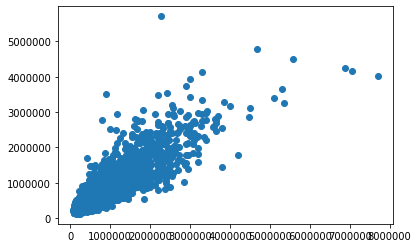

In [53]:
# Perform 6-fold cross validation
cv_predictions = cross_val_predict(rf, rf_features, rf_labels, cv=10)
plt.scatter(rf_labels, cv_predictions)

In [52]:
accuracy = metrics.r2_score(rf_labels, cv_prediction)
accuracy

0.8063942081970693

### Variable Importances

In [55]:
# Get numerical feature importances
rf_importances = list(rf.feature_importances_)
# List of tuples with variable and importance
rf_feature_importances = [(rf_feature, round(rf_importance, 2)) for rf_feature, rf_importance in zip(rf_feature_list, rf_importances)]
# Sort the feature importances by most important first
rf_feature_importances = sorted(rf_feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in rf_feature_importances];


Variable: sqft_living          Importance: 0.55
Variable: sqft_lot             Importance: 0.04
Variable: zipcode_98004        Importance: 0.04
Variable: bathrooms            Importance: 0.02
Variable: sqft_above           Importance: 0.02
Variable: view_0               Importance: 0.02
Variable: zipcode_98039        Importance: 0.02
Variable: zipcode_98112        Importance: 0.02
Variable: floors               Importance: 0.01
Variable: sqft_basement        Importance: 0.01
Variable: waterfront_0         Importance: 0.01
Variable: waterfront_1         Importance: 0.01
Variable: view_4               Importance: 0.01
Variable: condition_3          Importance: 0.01
Variable: grade_7              Importance: 0.01
Variable: grade_8              Importance: 0.01
Variable: grade_9              Importance: 0.01
Variable: grade_10             Importance: 0.01
Variable: zipcode_98023        Importance: 0.01
Variable: zipcode_98033        Importance: 0.01
Variable: zipcode_98040        Importanc

In [ ]:
# # New random forest with only the two most important variables
# rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)
# # Extract the two most important features
# rf_important_indices = [rf_feature_list.index('sqft_living'), rf_feature_list.index('sqft_lot'),rf_feature_list.index('zipcode_98004'),
#                      rf_feature_list.index('bathrooms'),rf_feature_list.index('sqft_above'),rf_feature_list.index('view_0'),
#                      rf_feature_list.index('zipcode_98039'),rf_feature_list.index('zipcode_98112')]
# rf_train_important = rf_train_features[:, rf_important_indices]
# rf_test_important = test_features[:, rf_important_indices]
# # Train the random forest
# rf_most_important.fit(rf_train_important, rf_train_labels)
# # Make predictions and determine the error
# predictions = rf_most_important.predict(rf_test_important)
# errors = abs(predictions - test_labels)
# # Display the performance metrics
# print('Mean Absolute Error:', round(np.mean(errors), 2), 'price.')
# mape = np.mean(100 * (errors / test_labels))
# accuracy = 100 - mape
# print('Accuracy:', round(accuracy, 2), '%.')

In [54]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
rf_x_values = list(range(len(rf_importances)))
# Make a bar chart
plt.bar(rf_x_values, rf_importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(rf_x_values, rf_feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

NameError: name 'rf_importances' is not defined

## 3 Layer Neural Network

In [12]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.datasets import load_wine
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

In [81]:
# sorted(hp_data) 

In [56]:
# Labels are the values we want to predict
nn_labels = np.array(df1['price'])
# Remove the labels from the features
# axis 1 refers to the columns
nn_features= df1.drop('price', axis = 1)
# Saving feature names for later use
nn_feature_list = list(nn_features.columns)
# Convert to numpy array
nn_features = np.array(nn_features)
#normalize features
nn_features = nn_features / np.linalg.norm(nn_features)


In [99]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
nn_train_features, nn_test_features, nn_train_labels, nn_test_labels = train_test_split(nn_features, nn_labels, test_size = 0.25, random_state = 42)

In [85]:
#nn_test_features

In [86]:
# train_dt = df1.sample(frac=0.8, random_state=0)
# test_dt = df1.drop(train_dt.index)

In [87]:
# train_stats = nn_train_features.describe()
# train_stats.pop('price')
# train_stats = train_stats.transpose()
# train_stats

In [88]:
# train_labels = train_dt.pop('price')
# test_labels = test_dt.pop('price')

In [89]:
# def norm(x):
#   return (x - train_stats['mean']) / train_stats['std']
# normed_train_data = norm(train_dt)
# normed_test_data = norm(test_dt)
# normed_train_data

In [101]:
def build_model():
  model = keras.Sequential([
    layers.Dense(105, activation='relu', input_shape=(155,)),
    layers.Dense(105, activation='relu'),
    layers.Dense(105, activation='relu'),  
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [102]:
model = build_model()

In [103]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 105)               16380     
_________________________________________________________________
dense_33 (Dense)             (None, 105)               11130     
_________________________________________________________________
dense_34 (Dense)             (None, 105)               11130     
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 106       
Total params: 38,746
Trainable params: 38,746
Non-trainable params: 0
_________________________________________________________________


In [104]:
#dict(normed_train_data.dtypes)

In [105]:
example_batch = nn_train_features[:10]
example_result = model.predict(example_batch)
example_result

array([[ 372.3052   ],
       [  13.477999 ],
       [ 332.00824  ],
       [  -4.8859067],
       [ 577.43207  ],
       [ 187.80435  ],
       [ 253.08226  ],
       [1751.3201   ],
       [ 191.27748  ],
       [  14.830503 ]], dtype=float32)

In [106]:
EPOCHS = 1000

# history = model.fit(
#   normed_train_data, train_labels,
#   epochs=EPOCHS, validation_split = 0.2, verbose=0,
#   callbacks=[tfdocs.modeling.EpochDots()])

In [107]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(nn_train_features, nn_train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:387348212292.7431,  mae:504579.0312,  mse:387348398080.0000,  val_loss:307476096962.0925,  val_mae:439168.8438,  val_mse:307476070400.0000,  
...............................

In [108]:
hist = pd.DataFrame(early_history.history)
hist['epoch'] = early_history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
26,6.649452e+10,169359.609375,6.649450e+10,5.570846e+10,166922.500000,5.570848e+10,26
27,6.641987e+10,169909.406250,6.641986e+10,5.580472e+10,166062.312500,5.580472e+10,27
28,6.632217e+10,169566.671875,6.632214e+10,5.568283e+10,166468.843750,5.568283e+10,28
29,6.632281e+10,169601.828125,6.632279e+10,5.597556e+10,167431.562500,5.597557e+10,29
30,6.629112e+10,170181.328125,6.629107e+10,5.580945e+10,167007.765625,5.580945e+10,30


In [109]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
# plotter.plot({'Early Stopping': early_history}, metric = "mae")
# plt.ylim([0, 1000000000000000])
# plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MAE [price]')

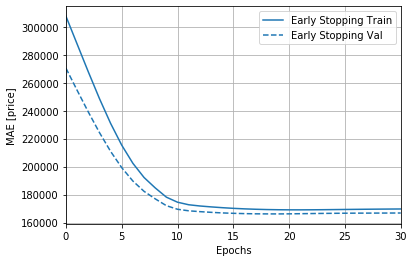

In [110]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylabel('MAE [price]')

In [111]:
loss, mae, mse = model.evaluate(nn_test_features, nn_test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} price".format(mae))

5404/5404 - 0s - loss: 73164328914.5226 - mae: 174403.0625 - mse: 73164349440.0000
Testing set Mean Abs Error: 174403.06 price


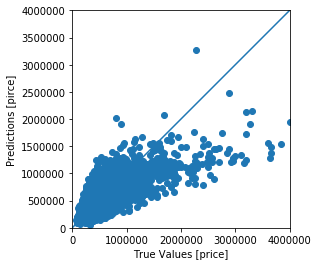

In [112]:
test_predictions = model.predict(nn_test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(nn_test_labels, test_predictions)
plt.xlabel('True Values [price]')
plt.ylabel('Predictions [pirce]')
lims = [0, 4000000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [38]:
# import plotly.express as px
# test_predictions = model.predict(nn_test_features).flatten()
# fig = px.scatter(x=nn_test_labels, y=test_predictions)
# fig.show()

In [57]:
# #viz with plotly
# import plotly.graph_objects as go

# random_x = np.array([0,7000000])
# random_y0 = np.array([0,7000000])

# fig = go.Figure()

# fig.add_trace(go.Scatter(x= nn_test_labels, y = test_predictions,
#                     mode='markers',
#                     name='markers'))

# fig.add_trace(go.Scatter(x=random_x, y=random_y0,
#                     mode='lines',
#                     name='lines'))

# fig.show()

NameError: name 'nn_test_labels' is not defined

In [ ]:
# test_predictions = model.predict(normed_test_data).flatten()

# a = plt.axes(aspect='equal')
# plt.scatter(test_labels, test_predictions)
# plt.xlabel('True Values [price]')
# plt.ylabel('Predictions [pirce]')
# lims = [0, 26]
# plt.xlim(lims)
# plt.ylim(lims)
# _ = plt.plot(lims, lims)

In [ ]:
# error = test_predictions - nn_test_labels
# plt.hist(error, bins = 25)
# plt.xlabel("Prediction Error [price]")
# _ = plt.ylabel("Count")